In [18]:
using Pkg
Pkg.activate(".")
# Pkg.add(url="https://github.com/marcelojbp/QuantumFCS")
using LinearAlgebra
using BenchmarkTools
using LaTeXStrings
using QuantumOptics
using CairoMakie
using SparseArrays
using IterativeSolvers
using QuantumFCS

  Activating project at `~/Library/CloudStorage/Dropbox/Work/Repos/QuantumFCS/notebooks`
┌ Warning: Module QuantumOptics with build ID fafbfcfd-051b-3d33-0000-601bbbbe272f is missing from the cache.
│ This may mean QuantumOptics [6e0679c1-51ea-5a7c-ac74-d61b76210b0c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948


In [19]:
N = 30
b_tls = NLevelBasis(3)
b_fock = FockBasis(N)
σ = [transition(b_tls, i, j) for i=1:3, j =1:3];
a = destroy(b_fock)
ad = create(b_fock)
Id_cav = one(b_fock)
Id_tls = one(b_tls)
;

In [20]:
function liouvQTLM(Δ, g, f, Jumps, rates)

    H = g*ad⊗σ[1,2] + f*a⊗one(b_tls)
    H += dagger(H) + Δ*Id_cav⊗σ[2,2]
    J = [rates[i]*Jumps[i] for i=1:length(rates)]
    return H, J
end

nBtoTω(n) = 1/log(1+1/n)

nBtoTω (generic function with 1 method)

In [21]:
g = 1.0
f = 0.1
# f = 3.0
Δ = 0.0
γh = 0.1
γc = 2.0
# κ = 100.0
κ = 1.0
nh = 5.0
nc = 0.027
ncav = 0.0001

Jumps = [Id_cav⊗σ[1, 3], Id_cav⊗σ[2, 3], a⊗Id_tls, Id_cav⊗σ[3, 1], Id_cav⊗σ[3, 2], ad⊗Id_tls]
rates = [√γh*√(nh+1), √γc√(nc+1), √κ√(ncav+1), √γh*√nh, √γc*√nc, √κ*√ncav]

f*g/κ

0.1

In [26]:

grange = [0.01:0.05:5.0;]
Jh_plt = similar(grange)
Jc_plt = similar(grange)
Jcav_plt = similar(grange)
𝒬g = similar(grange)
𝒬gp = similar(grange)


# g plots
for j=1:length(grange)
gp = grange[j]

    H, J =  liouvQTLM(Δ, gp, f, Jumps, rates)

    ρss = steadystate.iterative(H, J)
    ρss = (ρss + dagger(ρss))/2
    # println(g*f/κ)

    mJh= [J[1], J[4]]
    mJc= [J[2], J[5]]
    mJcav = [J[3], J[6]]

    Jh, Dh = fcscumulants_recursive(H, J, mJh, 2, ρss; iterative = :false)
    Jc, Dc = fcscumulants_recursive(H, J, mJc, 2, ρss; iterative = :false)
    Jcav, Dcav = fcscumulants_recursive(H, J, mJcav, 2, ρss; iterative = :false)

    Tωh = nBtoTω(nh)
    Tωc = nBtoTω(nc)
    Tωcav = nBtoTω(ncav)
    Σ = Jh/Tωh + Jc/Tωc + Jcav/Tωcav
    Σp = Jh/Tωh + Jc/Tωc 

    Jh_plt[j] = real(Jh)
    Jc_plt[j] = real(Jc)
    Jcav_plt[j] = real(Jcav)

    𝒬g[j] = real(Σ*Dh/Jh^2)
    𝒬gp[j] = real(Σp*Dh/Jh^2)
end


In [27]:

ncrange = [ncav:0.01:0.5;]
# Jh_plt = similar(grange)
# Jc_plt = similar(grange)
# Jcav_plt = similar(grange)
𝒬nc = similar(ncrange)
𝒬ncp = similar(ncrange)


# nc plots
for j=1:length(ncrange)
    
    ncp = ncrange[j]
    rates = [√γh*√(nh+1), √γc√(ncp+1), √κ√(ncav+1), √γh*√nh, √γc*√ncp, √κ*√ncav]
    H, J =  liouvQTLM(Δ, g, f, Jumps, rates)

    ρss = steadystate.iterative(H, J)
    ρss = (ρss + dagger(ρss))/2
    # println(g*f/κ)

    mJh= [J[1], J[4]]
    mJc= [J[2], J[5]]
    mJcav = [J[3], J[6]]

    Jh, Dh = fcscumulants_recursive(H, J, mJh, 2, ρss; iterative = :false)
    Jc, Dc = fcscumulants_recursive(H, J, mJc, 2, ρss; iterative = :false)
    Jcav, Dcav = fcscumulants_recursive(H, J, mJcav, 2, ρss; iterative = :false)

    Tωh = nBtoTω(nh)
    Tωc = nBtoTω(nc)
    Tωcav = nBtoTω(ncav)
    Σ = Jh/Tωh + Jc/Tωc + Jcav/Tωcav
    Σp = Jh/Tωh + Jc/Tωc 

    # Jh_plt[j] = real(Jh)
    # Jc_plt[j] = real(Jc)
    # Jcav_plt[j] = real(Jcav)

    𝒬nc[j] = real(Σ*Dh/Jh^2)
    𝒬ncp[j] = real(Σp*Dh/Jh^2)
end


# println(𝒬)
# println(𝒬p)

In [28]:

Δrange = [-1.0:0.1:1.0;]
# Jh_plt = similar(grange)
# Jc_plt = similar(grange)
# Jcav_plt = similar(grange)
𝒬Δ = similar(Δrange)
𝒬Δp = similar(Δrange)


# nc plots
for j=1:length(Δrange)
    
    Δp = Δrange[j]
    H, J =  liouvQTLM(Δp, g, f, Jumps, rates)

    ρss = steadystate.iterative(H, J)
    ρss = (ρss + dagger(ρss))/2
    # println(g*f/κ)

    mJh= [J[1], J[4]]
    mJc= [J[2], J[5]]
    mJcav = [J[3], J[6]]

    Jh, Dh = fcscumulants_recursive(H, J, mJh, 2, ρss; iterative = :false)
    Jc, Dc = fcscumulants_recursive(H, J, mJc, 2, ρss; iterative = :false)
    Jcav, Dcav = fcscumulants_recursive(H, J, mJcav, 2, ρss; iterative = :false)

    Tωh = nBtoTω(nh)
    Tωc = nBtoTω(nc)
    Tωcav = nBtoTω(ncav)
    Σ = Jh/Tωh + Jc/Tωc + Jcav/Tωcav
    Σp = Jh/Tωh + Jc/Tωc 

    # Jh_plt[j] = real(Jh)
    # Jc_plt[j] = real(Jc)
    # Jcav_plt[j] = real(Jcav)

    𝒬Δ[j] = real(Σ*Dh/Jh^2)
    𝒬Δp[j] = real(Σp*Dh/Jh^2)
end


# println(𝒬)
# println(𝒬p)

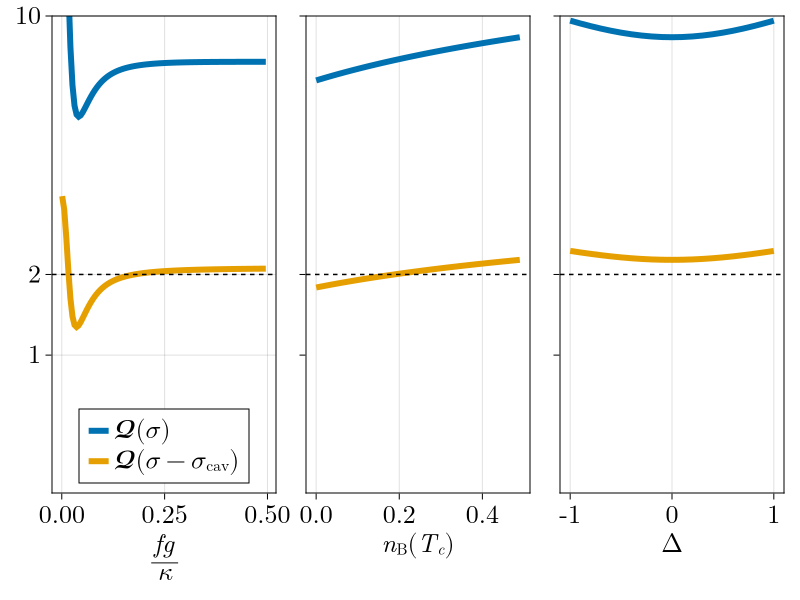

In [29]:
ϵrange = @. grange*f/κ;

lw=6
with_theme(theme_latexfonts()) do
    #|=== === === === Layout
        f = Figure(fontsize = 26, title = L"Bad-cavity TUR", size =(2000, 1200))
        ga = f[1,1] = GridLayout()
        gb = f[1,2] = GridLayout()
        gc = f[1,3] = GridLayout()
        # gc = f[2,3] = GridLayout()
        axa = Axis(ga[1,1], xlabel =L"\frac{fg}{\kappa}", yscale = Makie.pseudolog10)
        ylims!(0,10)
        axb = Axis(gb[1,1], xlabel =L"n_\text{B}(T_c)", yscale = Makie.pseudolog10)
        ylims!(0,10)
        axc = Axis(gc[1,1], xlabel =L"\Delta", yscale = Makie.pseudolog10)
        ylims!(0,10)
        # #|=== === ===  Fig. (aup)
        # lines!(axa, grange, Jh_plt, linewidth = lw, label = L"J_h")
        # lines!(axa, grange, Jc_plt, linewidth = lw, label = L"J_c")
        # lines!(axa, grange, Jcav_plt, linewidth = lw, label = L"J_\text{cav}")
        # lines!(axa, grange, -(Jh_plt + Jc_plt + Jcav_plt), linewidth = lw, label = L"W")
        #|=== === ===  Fig. (a)
        # lines!(axa, grange, 𝒬g , linewidth = lw)
        lines!(axa, ϵrange, 𝒬g, linewidth = lw, label = L"\mathcal{Q}(\sigma)")
        lines!(axa, ϵrange, 𝒬gp, linewidth = lw, label = L"\mathcal{Q}(\sigma-\sigma_\text{cav}) ")
        hlines!(axa, [2], linestyle = :dash, color = :black)
        # current_figure()
        # axb.xticks = 0:tf/2:tf
        # #|=== === ===  Fig. (b)
        # lines!(axa, grange, 𝒬g , linewidth = lw)
        lines!(axb, ncrange, 𝒬nc, linewidth = lw, label = L"\mathcal{Q}")
        lines!(axb, ncrange, 𝒬ncp, linewidth = lw, label = L"\mathcal{Q}'")
        hlines!(axb, [2], linestyle = :dash, color = :black)
                # #|=== === ===  Fig. (b)
        # lines!(axa, grange, 𝒬g , linewidth = lw)
        lines!(axc, Δrange, 𝒬Δ, linewidth = lw, label = L"\mathcal{Q}_h")
        lines!(axc, Δrange, 𝒬Δp, linewidth = lw, label = L"\mathcal{Q}_h'")
        hlines!(axc, [2], linestyle = :dash, color = :black)
        axa.yticks = [1, 2, 10, 50]
        # axa.xticks =  [first(ϵrange):last(ϵrange)/2:last(ϵrange);]
        axa.xticks =  [0.0, 0.25, .5]
        axb.yticks = [1, 2, 10, 50]
        axc.xticks = [-1,0, 1]
        axc.xticks = [-1,0, 1]
        axc.yticks = [1, 2, 10, 50]
        # axislegend(axb, position=:rt)
        hideydecorations!(axb, ticks = false)
        hideydecorations!(axc, ticks = false)
        linkyaxes!(axa, axb)
        linkyaxes!(axb, axc)
        current_figure()
        axislegend(axa, position=:cb)
        f
    end

In [7]:
function fcscumulants_recursive_test(L::SparseMatrixCSC{ComplexF64, Int64}, mJ::Vector, nC::Int64, rho_ss; apply = :true, nu = vcat(fill(+1, Int(length(mJ)/2)),fill(-1, Int(length(mJ)/2))), iterative = :true)
    l = length(rho_ss)
    s = size(rho_ss)
    # Identity in Liouville space
    IdL = spdiagm(ComplexF64.(ones(l)))
    # Vectorired identity operator
    vId = vec(spdiagm(ComplexF64.(ones(s[1]))))'
    # Jump d/dχ n-derivatives, ℒ(n)
    Ln = [m_jumps(mJ; n = k, nu = nu) for k=1:nC]
    # Vectorized steady-state
    vrho_ss = SparseVector(vec(rho_ss))
    # Empty list which will collect the cumulants
    vI = Vector{Float64}(undef, nC)
    # First cumulant, computed directly
    vI[1] = real(vId⋅(Ln[1]*vrho_ss))
    # If we are interested in any higher cumulant we start to use the recursive scheme
    # Initializing the list of "states" used in the recursion
    # We set the first to be the steady-state
    # vrho[1] = vrho_ss
    vrho = [vrho_ss for j=1:nC]
    # vrho[1] = vrho_ss
    #  We now can compute the Drazin inverse directly or use the drazin_apply function
    # if apply == :false
    #     # Computing the Drazin inverse
    #     LD = drazin(L, vrho_ss, vId, IdL)
    #     for n = 2:nC
    #     #Computing the "states" 
    #     valpha = sum(binomial(n-1, m)*(vI[m]*IdL*vrho[n-m] - Ln[m]*vrho[n-m]) for m=1:n-1)
    #     vrho[n] = LD*valpha
    #     # and the n-th cumulant
    #     append!(vI, real(vId*(sum(binomial(n, m)*Ln[m]*vrho[n+1-m] for m=1:n))))
    #         end
    #     else
        for n = 2:nC
            # Here we do the same but using the drazin_apply function
            valpha = sum(binomial(n-1, m)*(vI[m]*vrho[n-m] - Ln[m]*vrho[n-m]) for m=1:n-1)
            vrho[n] = drazin_apply_test(L, valpha, vrho_ss, vId; iterative = iterative)
            vI[n] = real(sum(binomial(n, m)*vId⋅(Ln[m]*vrho[n+1-m]) for m=1:n))
            end 
    # end

    return vI
end

function fcscumulants_recursive_test(H::Operator, J, mJ, nC, rho_ss::Operator; kargs...)
    L = liouvillian(H, J).data    
    return fcscumulants_recursive_test(L, getfield.(mJ,:data), nC ,rho_ss.data; kargs...)
end   


function drazin_apply_test(L::SparseMatrixCSC{ComplexF64, Int64}, alphavec::SparseVector, vrho_ss::SparseVector, vId::AbstractMatrix; iterative=:true)
    # constructing the left hand side consiting of the liouvillian and the unit matrix row 
    lhs = cat(L, vId; dims = 1)
    # constructing the right hand side of the linear system 
    alphavecp = alphavec - vrho_ss .* (vId*alphavec)
    j, v = findnz(alphavecp)
    rhs = SparseVector(length(alphavecp)+1, j, v)
    ## returning the result 
    # return lhs\Vector(rhs)
    # return qr(lhs)\rhs
    if iterative == :true
        # return IterativeSolvers.gauss_seidel(lhs, Vector(rhs))
        # return qr(lhs)\Vector(rhs)
        return IterativeSolvers.lsqr(lhs, rhs)
    else
         return  lhs\Vector(rhs)
    end
end 

drazin_apply_test (generic function with 1 method)